In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
pjme = pd.read_csv('/Users/sean/Downloads/energy_forecast/PJME_hourly.csv',
                  index_col=[0], parse_dates=[0])

In [3]:
plt.style.use('fivethirtyeight')

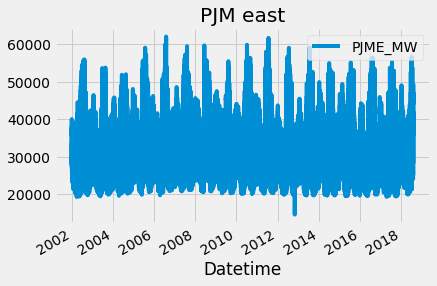

In [4]:
pjme.plot(title='PJM east')

In [5]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [7]:
def extract_window(dataframe): 
    cols = []
    for i in range(10, -1, -1): 
        cols.append(dataframe.shift(i))
        
    df= pd.concat(cols, axis=1)
    df.columns = ['t-%d' %k for k in range(10, -1, -1)]
    df = df.dropna()
    x = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    return x, y

In [8]:
pjme_x, pjme_y = extract_window(pjme)

In [9]:
def extract_feats(df): 
    df['date'] = df.index.day
    df['month']  = df.index.month
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear
    df['day_of_week'] = df.index.dayofweek
    df['week_of_year'] = df.index.weekofyear
    return df

In [10]:
pjme_x = extract_feats(pjme_x)
pjme_x.head()

/anaconda3/envs/ee127/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,date,month,hour,day_of_year,day_of_week,week_of_year
Datetime,,,,,,,,,,,,,,,,
2002-12-31 11:00:00,26498.0,25147.0,24574.0,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,31,12,11,365,1,1
2002-12-31 12:00:00,25147.0,24574.0,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31,12,12,365,1,1
2002-12-31 13:00:00,24574.0,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31902.0,31,12,13,365,1,1
2002-12-31 14:00:00,24393.0,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31902.0,31126.0,31,12,14,365,1,1
2002-12-31 15:00:00,24860.0,26222.0,28702.0,30698.0,31800.0,32359.0,32371.0,31902.0,31126.0,30368.0,31,12,15,365,1,1


In [11]:
split_date = '01-01-2015'

x_tr = pjme_x.loc[pjme_x.index < split_date]
y_tr = pjme_y.loc[pjme_y.index < split_date]

x_te = pjme_x.loc[pjme_x.index >= split_date]
y_te = pjme_y.loc[pjme_y.index >= split_date]

In [12]:
from xgboost import XGBRegressor

In [13]:
model = XGBRegressor()

In [14]:
# Make the dataset
x_te = x_te[10:]
y_te = y_te[10:]

In [15]:
x_te.values.shape

(31430, 16)

In [16]:
import ray
from ray import tune
# ray.services.get_node_ip_address = lambda: '127.0.0.1'
ray.init(local_mode=True,num_cpus=1, num_gpus=0)

2020-12-09 21:15:56,569	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.4.26',
 'raylet_ip_address': '192.168.4.26',
 'redis_address': '192.168.4.26:29453',
 'object_store_address': '/tmp/ray/session_2020-12-09_21-15-55_935661_94652/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-09_21-15-55_935661_94652/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2020-12-09_21-15-55_935661_94652',
 'metrics_export_port': 51059,
 'node_id': 'eb7aa5e69d4fa84a1ba90dd5cddbaa564bc75372'}

In [17]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

In [18]:
class MyModel(Model):
    def __init__(self, hid1, hid2): 
        super(MyModel, self).__init__()
        self.d1 = Dense(hid1, activation='relu')
        self.d2 = Dense(hid2, activation='relu')
        self.d3 = Dense(1)
        
    def call(self, x): 
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [19]:
def load_data(): 
    return (x_tr.values, y_tr.values), (x_te.values, y_te.values)

In [23]:
class TSTrainer(tune.Trainable): 
    def setup(self, config): 
        
        import tensorflow as tf
        
        (x_train, y_train), (x_test, y_test) = load_data()
        
        self.train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
        self.test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
        
        self.model = MyModel(hid1=config['hid1'], 
                            hid2=config['hid2'])
        
        self.loss_func = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(lr=config['lr'])
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.test_loss= tf.keras.metrics.Mean(name='test_loss')
        self.train_mae = tf.keras.metrics.MeanAbsoluteError()
        self.test_mae = tf.keras.metrics.MeanAbsoluteError()
        
        @tf.function
        def train_step(x, y): 
            with tf.GradientTape() as tape:
                pred = self.model(x)
                loss = self.loss_func(y, pred)
                self.train_mae(pred, y)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(
                zip(gradients, self.model.trainable_variables))
            self.train_loss(loss)
            

        @tf.function
        def test_step(x, y): 
            pred = self.model(x)
            loss = self.loss_func(y, pred)
            self.test_loss(loss)
            self.test_mae(pred, y)
        
        self.tf_train_step = train_step
        self.tf_test_step = test_step
        
    def step(self): 
        self.train_loss.reset_states()
        self.test_loss.reset_states()
        self.train_mae.reset_states()
        self.test_mae.reset_states()
        
        for i, (x, y) in enumerate(self.train_ds): 
            self.tf_train_step(x, y)
        for i, (x, y) in enumerate(self.test_ds): 
            self.tf_test_step(x, y)
            
        return{ 
            'epoch': self.iteration, 
            'loss': self.train_loss.result().numpy(), 
            'test_loss': self.test_loss.result().numpy(),
            'mae': self.train_mae.result().numpy(),
            'test_mae': self.test_mae.result().numpy()
        }
        
        
    

In [26]:
load_data()

from ray.tune.schedulers import AsyncHyperBandScheduler
sched = AsyncHyperBandScheduler(max_t=30, grace_period=20)




analysis = tune.run(
    TSTrainer, 
    metric='test_loss',
    scheduler=sched,
    mode='min',
    stop={'training_iteration':5},
    verbose=2,
    num_samples=3
    config={'hid1':tune.choice([32, 64, 128]), 
           'hid2':tune.choice([32, 64, 128]),
            'lr':tune.choice([1e-3, 1e-5])
           }
)

analysis.best_config


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



2020-12-09 21:20:53,761	WARNING util.py:140 -- The `start_trial` operation took 3.230520725250244 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,hid1,hid2,lr
TSTrainer_77815_00000,RUNNING,,32,32,0.001


Result for TSTrainer_77815_00000:
  date: 2020-12-09_21-20-53
  done: false
  epoch: 0
  experiment_id: 2cd8c20684d041d5bcef8a1dcf79b5f6
  experiment_tag: 0_hid1=32,hid2=32,lr=0.001
  hostname: admins-MacBook-Pro.local
  iterations_since_restore: 1
  loss: 3687039.75
  mae: 1113.3118896484375
  node_ip: 192.168.4.26
  pid: 94652
  test_loss: 1506934.375
  test_mae: 876.267822265625
  time_since_restore: 2.848219871520996
  time_this_iter_s: 2.848219871520996
  time_total_s: 2.848219871520996
  timestamp: 1607577653
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '77815_00000'
  


2020-12-09 21:20:56,007	WARNING util.py:140 -- The `process_trial` operation took 2.2423901557922363 seconds to complete, which may be a performance bottleneck.
2020-12-09 21:20:58,315	WARNING util.py:140 -- The `process_trial` operation took 2.306978940963745 seconds to complete, which may be a performance bottleneck.
2020-12-09 21:21:00,546	WARNING util.py:140 -- The `process_trial` operation took 2.2290902137756348 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,hid1,hid2,lr,iter,total time (s),epoch,loss,test_loss
TSTrainer_77815_00000,RUNNING,192.168.4.26:94652,32,32,0.001,3,7.39321,2,1.03616e+06,1.84913e+06


Result for TSTrainer_77815_00000:
  date: 2020-12-09_21-21-00
  done: false
  epoch: 3
  experiment_id: 2cd8c20684d041d5bcef8a1dcf79b5f6
  experiment_tag: 0_hid1=32,hid2=32,lr=0.001
  hostname: admins-MacBook-Pro.local
  iterations_since_restore: 4
  loss: 975658.0
  mae: 671.6181640625
  node_ip: 192.168.4.26
  pid: 94652
  test_loss: 2152911.0
  test_mae: 1087.562255859375
  time_since_restore: 9.620939254760742
  time_this_iter_s: 2.2277321815490723
  time_total_s: 9.620939254760742
  timestamp: 1607577660
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: '77815_00000'
  


2020-12-09 21:21:02,766	WARNING util.py:140 -- The `process_trial` operation took 2.2161850929260254 seconds to complete, which may be a performance bottleneck.


Result for TSTrainer_77815_00000:
  date: 2020-12-09_21-21-02
  done: true
  epoch: 4
  experiment_id: 2cd8c20684d041d5bcef8a1dcf79b5f6
  experiment_tag: 0_hid1=32,hid2=32,lr=0.001
  hostname: admins-MacBook-Pro.local
  iterations_since_restore: 5
  loss: 934310.875
  mae: 650.7478637695312
  node_ip: 192.168.4.26
  pid: 94652
  test_loss: 2501518.5
  test_mae: 1188.096435546875
  time_since_restore: 11.833644151687622
  time_this_iter_s: 2.21270489692688
  time_total_s: 11.833644151687622
  timestamp: 1607577662
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: '77815_00000'
  


Trial name,status,loc,hid1,hid2,lr,iter,total time (s),epoch,loss,test_loss
TSTrainer_77815_00000,TERMINATED,,32,32,0.001,5,11.8336,4,934311,2.50152e+06


2020-12-09 21:21:02,777	INFO tune.py:439 -- Total run time: 12.55 seconds (12.38 seconds for the tuning loop).


{'hid1': 32, 'hid2': 32, 'lr': 0.001}